In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from numpy.random import seed, normal, uniform

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

In [2]:
def output(sim,planets,resonances,threebodyresonances,outputs):
    t,P,e,Pratio,phi1,phi2,deltapomega,phi3body = outputs
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(sim.t)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            t[pair].append(sim.t)
            if resonance[1] is not None:
                res = resonance[1]
                p = res[1]
                q = res[0]-res[1]
                phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
                phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
                deltapomega[pair].append(wrap(ps[p2].pomega - ps[p1].pomega))
        except:
            pass
        
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        p1 = triad[0]
        p2 = triad[1]
        p3 = triad[2]
        res = resonance[1]
        p = res[0]
        q = res[1]
        try:
            phi3body[triad].append(wrap(p*ps[p1].l - (p+q)*ps[p2].l + q*ps[p3].l))
            t[triad].append(sim.t)
        except:
            pass

In [3]:
def plot(planets,resonances,threebodyresonances,outputs):
    t,P,e,Pratio,phi1,phi2,deltapomega,phi3body = outputs
    fig, axarr = plt.subplots(ncols=2, nrows=4, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        if res is not None:
            resratio = res[0]/res[1]
            axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
            axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
            axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
            axarr[3,0].plot(t[pair], deltapomega[pair], '.', label=pair)
            axarr[2,0].set_ylim([0.,360])
            axarr[2,1].set_ylim([0.,360])
    for resonance in threebodyresonances.items():
        triad = resonance[0]
        axarr[3,1].plot(t[triad], phi3body[triad], '.', label=triad)
    
    for ax in axarr.flatten():
        ax.legend(loc='upper right')
    return fig

In [12]:
def removedamping(sim, Tremoval, K, planets, resonances, threebodyresonances, outputs): # Tremovel in # of taue0s
    ps = sim.particles
    taue0 = ps[-1].params["tau_e"]
    T0 = sim.t
    print(T0)
    T = abs(taue0)*Tremoval
    Nout = 1000
    times = np.linspace(T0, T0+T, Nout)
    
    for i, time in enumerate(times):
        for p in ps[1:]:
            p.params["tau_e"] = taue0/(1.-(sim.t-T0)/T)
            try: # try except so we don't assign a tau_a to planets that don't have it
                has_tau_a = p.params["tau_a"]
                p.params["tau_a"] = taue0*K/(1.-(sim.t-T0)/T)
            except:
                pass
        sim.integrate(time)
        output(sim,planets,resonances,threebodyresonances,outputs)
        
    for p in ps[1:]:
        p.params["tau_e"] = np.inf
        p.params["tau_a"] = np.inf

def integrate(sim, T, planets, resonances, threebodyresonances, outputs):
    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0, T0+T, Nout)
    ps = sim.particles
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,planets,resonances,threebodyresonances,outputs)
        
def initialize(planets, resonances, threebodyresonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        deltapomega[pair] = []
        
    for triad in threebodyresonances.keys():
        t[triad] = []
        phi3body[triad] = []
        
    return (t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body)

In [5]:
def drawnormal(pair):
    mean, sigma = pair
    val = -1
    while val < 0:
        val = normal(mean, sigma)
    return val

In [6]:
def res_chain_setup(sim, planets, resonances, delta):
    masses, incs, Omegas, thetas = {}, {}, {}, {}

    for p in planets:
        masses[p] = drawnormal(massdist[p])
        incs[p] = drawnormal(incdist[p])
        Omegas[p] = uniform(0,2*np.pi)
        thetas[p] = uniform(0,2*np.pi)

    ps = sim.particles
    sim.add(m=1.)
    
    p0 = planets[0]
    sim.add(m=masses[p0],a=1., inc=incs[p0], Omega=Omegas[p0], theta=thetas[p0], hash=p0)
    
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        res = resonance[1]
        p = res[1]
        q = res[0]-res[1]
        sim.add(m=masses[p2],P=(p+q)/p*sim.particles[-1].P*(1.+delta), inc=incs[p2], Omega=Omegas[p2], theta=thetas[p2], hash=p2)
        
    sim.move_to_com() # Moves to the center of momentum frame

In [7]:
incdist = {'b':[89.65,0.27], 'c':[89.67, 0.17], 'd':[89.75,0.16], 'e':[89.86, 0.12], 'f':[89.68,0.034], 'g':[89.710,0.025], 'h':[89.8, 0.3]}
for inc in incdist.values():
    inc[0] = (90-inc[0])*np.pi/180.
    inc[1] *= np.pi/180.

    massdist = {'b':[0.85,0.72], 'c':[1.38,0.61], 'd':[0.41,0.27], 'e':[0.62,0.58], 'f':[0.68,0.18], 'g':[1.34,0.88], 'h':[0.41, 0.27]}
Mearth = 3.e-6
Mstar = 0.08
for mass in massdist.values():
    mass[0] *= Mearth/Mstar
    mass[1] *= Mearth/Mstar

In [8]:
planets = ['b', 'c', 'd', 'e', 'f', 'g', 'h']
resonances = OrderedDict([(('b','c'),(8,5)),(('c','d'),(5,3)),(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3)),(('g','h'),(3,2))]) # ordered so we add planets in right sequence
threebodyresonances = OrderedDict([(('b','c','d'),(2,3)),(('c','d','e'),(1,2)),(('d','e','f'),(2,3)),(('e','f','g'),(1,2)),(('f','g','h'),(1,1))])

simID=0
seed(simID)
K = 10**uniform(1,3)
print(K)

125.20653814999461


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 2min 7s, sys: 0 ns, total: 2min 7s
Wall time: 2min 7s


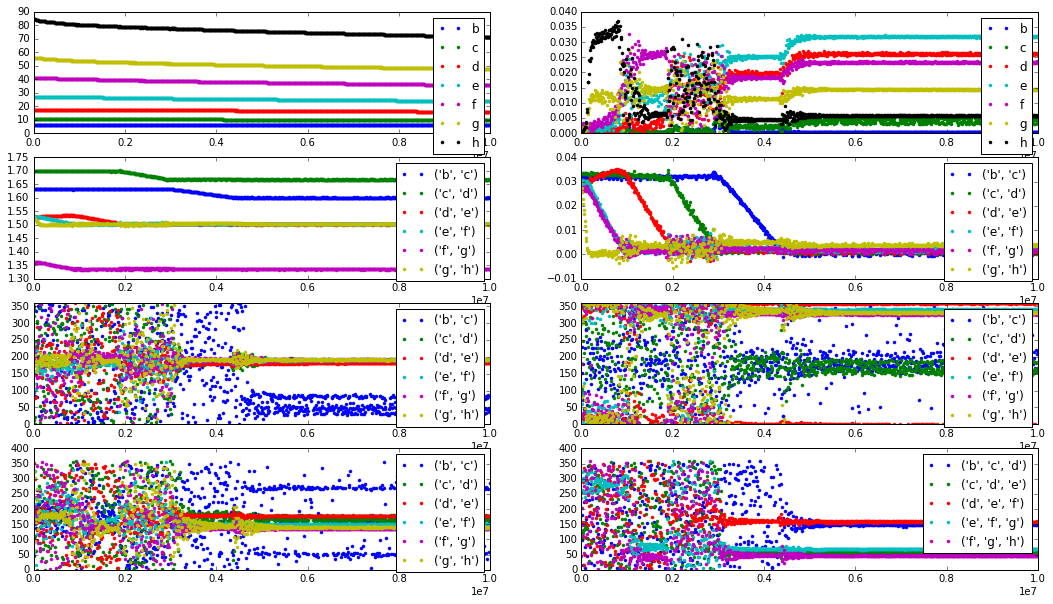

In [9]:
%%time
sim = rebound.Simulation()
ps = sim.particles

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")

delta=2.e-2 # fractional distance to start beyond resonance. Would be better to calculate relative to width of resonance

res_chain_setup(sim, planets, resonances, delta)

sim.integrator="whfast"
sim.dt=ps[1].P*0.07

outputs = initialize(planets, resonances, threebodyresonances)

taua = 1.e7
taue = taua/K

for p in ps[1:]:
    p.params["tau_e"] = -taue
ps['h'].params["tau_a"] = -taua

T = taua*delta*50
Nout = 1000

times = np.linspace(sim.t,sim.t+T,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    output(sim,planets,resonances,threebodyresonances,outputs)
plot(planets,resonances,threebodyresonances,outputs);

10000000.0


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


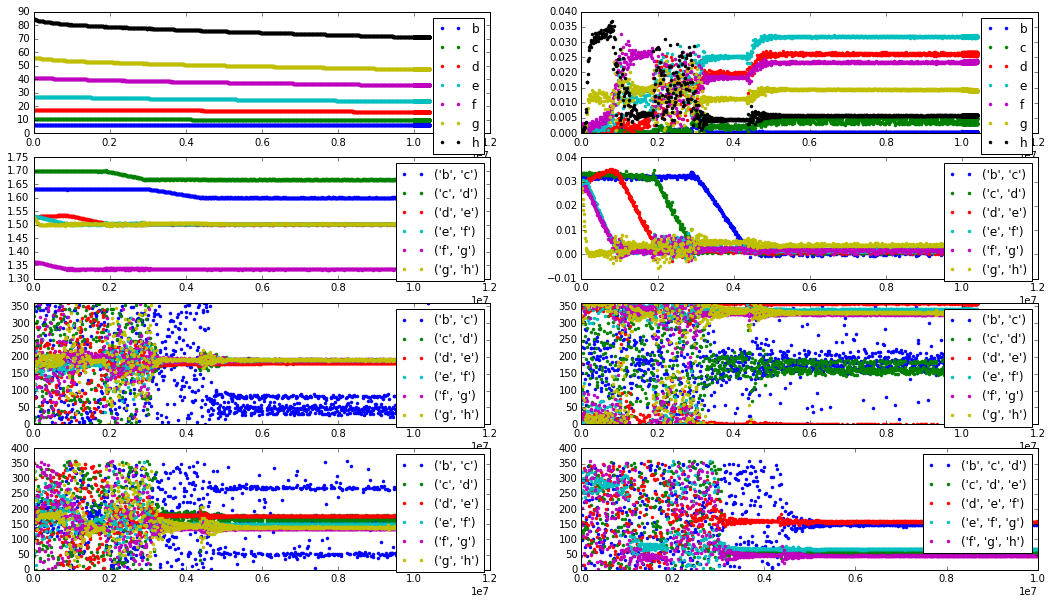

In [13]:
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body, planets,resonances,threebodyresonances)
plot(t,P,e,Pratio,phi1,phi2,deltapomega,phi3body,planets,resonances,threebodyresonances);

In [14]:
sim.save("7p.bin")

In [56]:
sim = rebound.Simulation.from_file("7p.bin")

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:375: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)


In [57]:
mag = 0.001#10**uniform(-3,0)
print(mag)

sim2 = rebound.Simulation()
sim2.G = 4*np.pi**2
sim2.add(m=Mstar)

Pd = 4.0496/365.25

mscale = Mstar/sim.particles[0].m
Pscale = Pd/sim.particles['d'].P

ps = sim.particles
for p in planets: 
    r = uniform(-1,1)
    sign = abs(r)/r # get +/- 1 randomly
    sim2.add(m=ps[p].m*mscale, P=ps[p].P*Pscale, e=ps[p].e*(1. + sign*mag), inc=ps[p].inc, pomega=ps[p].pomega, Omega=ps[p].Omega, theta=ps[p].theta, hash=p)

sim2.move_to_com()

0.001


In [58]:
sim = sim2
ps = sim.particles
sim.integrator="whfast"
sim.dt=ps[1].P*0.07

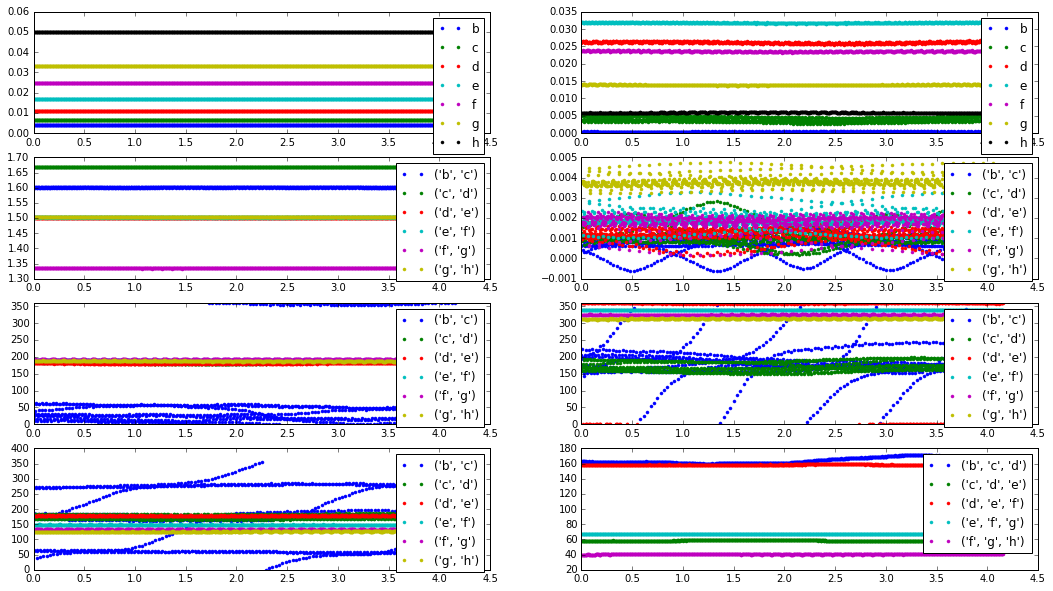

In [59]:
t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body = initialize(planets, resonances, threebodyresonances)
  
integrate(sim, 1.e3*ps[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, deltapomega, phi3body, planets, resonances, threebodyresonances)
plot(t,P,e,Pratio,phi1,phi2,deltapomega,phi3body,planets,resonances,threebodyresonances);

In [40]:
for i in range(1,sim.N-1):
    print(sim2.particles[i+1].P/sim2.particles[i].P)

1.6327415382145345
1.7006309908175545
1.5019013181929173
1.5029444519037396
1.3355335176984309
1.5059013392795304


In [41]:
sim.save("dissipationscaling.bin")

In [14]:
sim = rebound.Simulation.from_file("test.bin")
ps = sim.particles

In [15]:
taue = 1.e8
reboundx.Extras(sim)
rebx.add("tides_synchronous_ecc_damping")
ps[1].params["tides_synchronous_tau_e"] = -taue

In [17]:
K=125
filename='testIC{0}K{1:.4e}mag{2:.4e}taue{3:.2e}'.format(simID, K, mag, taue)
rebx.save(filename+'rebx.bin')
sim.initSimulationArchive(filename+'.bin', interval=1.e3)
sim.integrate(2.e3)

NameError: name 'mag' is not defined

IC0K1.2521e+02mag5.0734e-02taue1.00e+01
CPU times: user 3min 30s, sys: 36 ms, total: 3min 31s
Wall time: 3min 31s


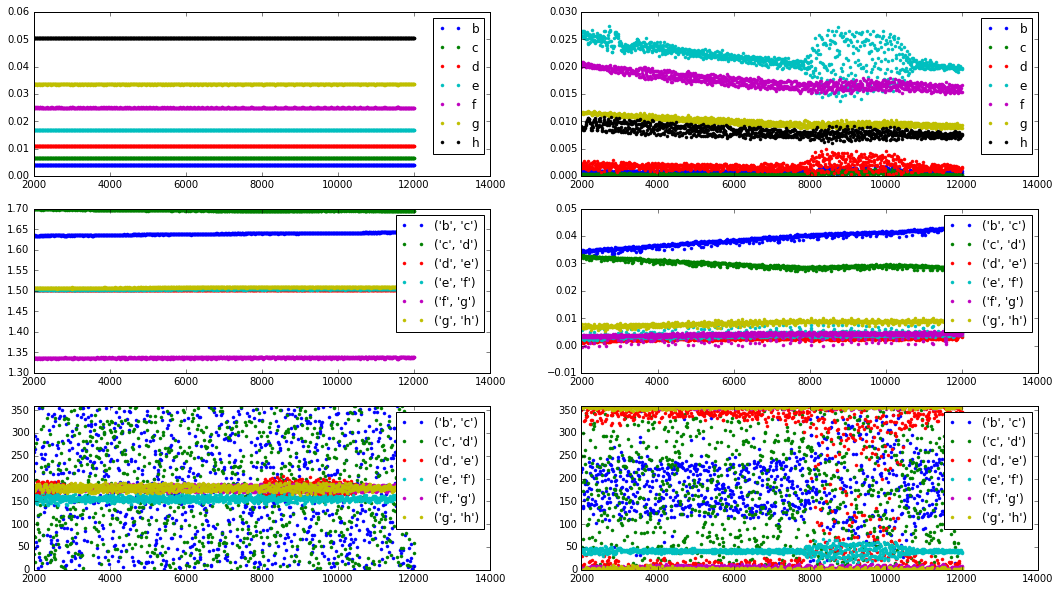

In [96]:
%%time
import os
import re

path = '7pdissipation/data/'
for filename in os.listdir(path):
    result = re.search("IC{0}K(.*)[0-9].bin".format(simID), filename)
    if result:
        print(filename[:-4])
        sim = rebound.SimulationArchive(path+filename)[-1]
        sim.simulationarchive_filename = (path+filename).encode('ascii')
        rebx = reboundx.Extras.from_file(sim, path+filename[:-4]+'rebx.bin')
        damping = rebx.get_effect("tides_synchronous_ecc_damping")
        rebx.integrator="rk4"
        damping.force_as_operator = 1
        t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
        integrate(sim, 1.e4, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
        plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [13]:
%%time
import os
import re
import rebound
import reboundx

simID=11
path = '7pdissipation/data/'
for filename in os.listdir(path):
    result = re.search("IC{0}K(.*)[0-9].bin".format(simID), filename)
    if result:
        print(filename[:-4])
        sim = rebound.SimulationArchive(path+filename)[-1]
        sim.simulationarchive_filename = (path+filename).encode('ascii')
        rebx = reboundx.Extras.from_file(sim, path+filename[:-4]+'rebx.bin')
        damping = rebx.get_effect("tides_synchronous_ecc_damping")
        rebx.integrator="rk4"
        damping.force_as_operator = 1

IC11K2.2937e+01mag3.4989e-01taue3.16e+07
CPU times: user 2 ms, sys: 4 ms, total: 6 ms
Wall time: 24.8 ms


In [12]:
sim.t

13000.0

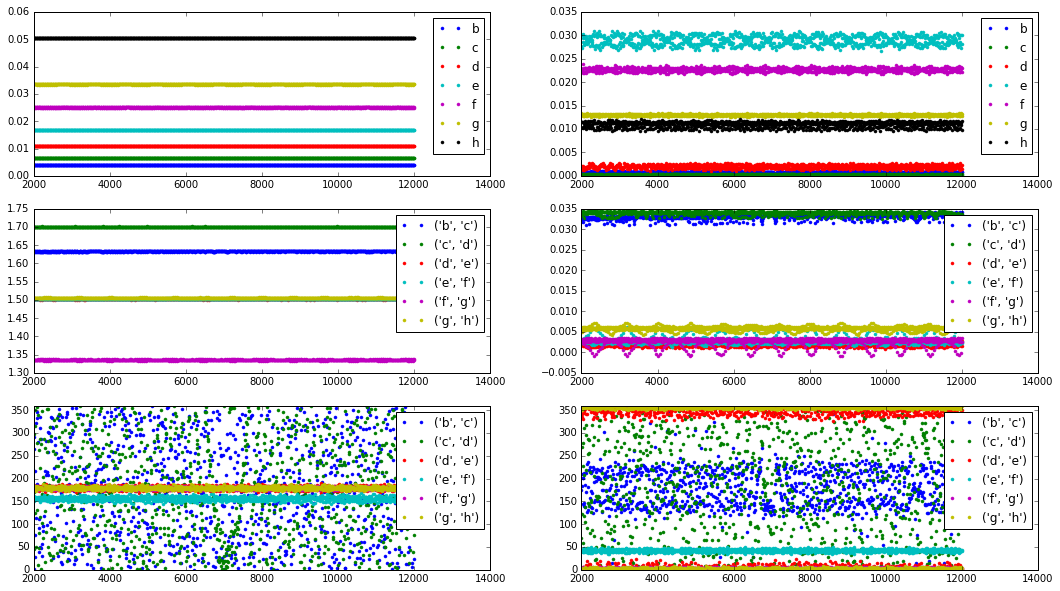

In [89]:
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [92]:
sim.particles[1].e

0.0009349643322612121

In [44]:
filename='data/IC{0}K{1:.4e}mag{2:.4e}.bin'.format(simID, K, mag)
sa = rebound.SimulationArchive(filename)
sim = sa[0]


In [45]:
sim.t

421.96284751156304

In [55]:
with open("test.txt", "a+") as f:
    f.seek(0)
    print(f.readlines())

['0\n', '1\n', '2\n', '3\n', '\n']
